In [ ]:
import os
import time
import pandas as pd
import numpy as np
from scipy.stats import uniform
import matplotlib.pyplot as plt
import matplotlib_inline
import seaborn as sns
import mglearn

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.svm import SVR

# Import helperfunctions
from ML_functions import fun_load_file, fun_preprocessing

# Start time count
start_script = time.time()

# Assign string 'TSP' or 'CVRP' to the following variable to define the routing problem
routing_problem = 'TSP'

# Get the name of the folder and the file to store the final DataFrame
if (routing_problem == 'TSP'):
    folder = '01_TSP'
    file_name = 'tsp_instances_j_updated.xlsx'
elif (routing_problem == 'CVRP'):
    folder = '02_CVRP'
    file_name = 'cvrp_instances_j_updated.xlsx'

# Load data
data = fun_load_file(subfolder_path='..\\01_data\\' + folder, name=file_name)
X, y, train_data = fun_preprocessing(data)

# Create a train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95, random_state=0)

# Save train size and create a dictionary to store the results
train_size = f'{int(np.round(100 * len(X_train)/len(X)))} %'
results_dict = {}

In [ ]:
# Function to plot a heatmap with the grid search cv scores (MAPE) of the parameter combinations
def plot_heatmap(scores_list, param_grid, different_scalers=True):
    if (different_scalers == True): scalers_list = [StandardScaler(), MinMaxScaler(), RobustScaler()]
    parameters = list(param_grid.keys())

    # Reshape the scores array for heatmap
    if (len(parameters) == 1):
        n_rows = 1
        n_cols = -1
        y_ticklabels = []
        plotsize = (18, 1)

    elif (len(parameters) == 2):
        n_rows = len(list(param_grid.values())[0])
        n_cols = len(list(param_grid.values())[1])
        y_ticklabels = param_grid[parameters[1]]
        y_label = parameters[1]
        plotsize = (18, 6)
    
    else: print('Too many parameters')

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=plotsize)

    # Iterate over all scalers
    for scaler, ax in enumerate(axes):
        scores = scores_list[scaler].reshape(n_rows, n_cols) 

        sns.heatmap(scores, annot=True, fmt=".2f", cmap='viridis', xticklabels=param_grid[parameters[0]], yticklabels=y_ticklabels, ax=ax)
        ax.set_xlabel(parameters[0])
        if (len(parameters) !=1): ax.set_ylabel(y_label)
        ax.set_title(scalers_list[scaler])
            
        # Annotating each cell with its corresponding score
        for i in range(len(scores)):
            for j in range(len(scores[i])):
                text = ax.text(j + 0.5, i + 0.5, f"{scores[i, j]:.2f}", ha='center', va='center', color='darkgrey')

# **Support Vector Machines with Kernels - Kernel Machines**

**Scaling**

In [10]:
# Standardscaler
standard = StandardScaler()

standard.fit(X_train)
X_train_standard = standard.transform(X_train)
X_test_standard = standard.transform(X_test)

# Minmaxscaler
minmax = MinMaxScaler()

minmax.fit(X_train)
X_train_minmax = minmax.transform(X_train)
X_test_minmax = minmax.transform(X_test)

# Robustsclaer
robust = RobustScaler()

robust.fit(X_train)
X_train_robust = robust.transform(X_train)
X_test_robust = robust.transform(X_test)

X_train_dict = {'Standard scaler': X_train_standard, 
                'Minmax scaler': X_train_minmax,
                'Robust scaler': X_train_robust}

### **Gaussian Kernel**

----------Standard scaler----------
Fitting 3 folds for each of 16 candidates, totalling 48 fits
MAPE on train data with {'C': 150, 'gamma': 0.01}: 4.04 %
Computation time: 26948.1 seconds

----------Minmax scaler----------
Fitting 3 folds for each of 16 candidates, totalling 48 fits
MAPE on train data with {'C': 650, 'gamma': 0.1}: 3.51 %
Computation time: 25302.57 seconds

----------Robust scaler----------
Fitting 3 folds for each of 16 candidates, totalling 48 fits
MAPE on train data with {'C': 500, 'gamma': 0.01}: 3.94 %
Computation time: 31375.32 seconds



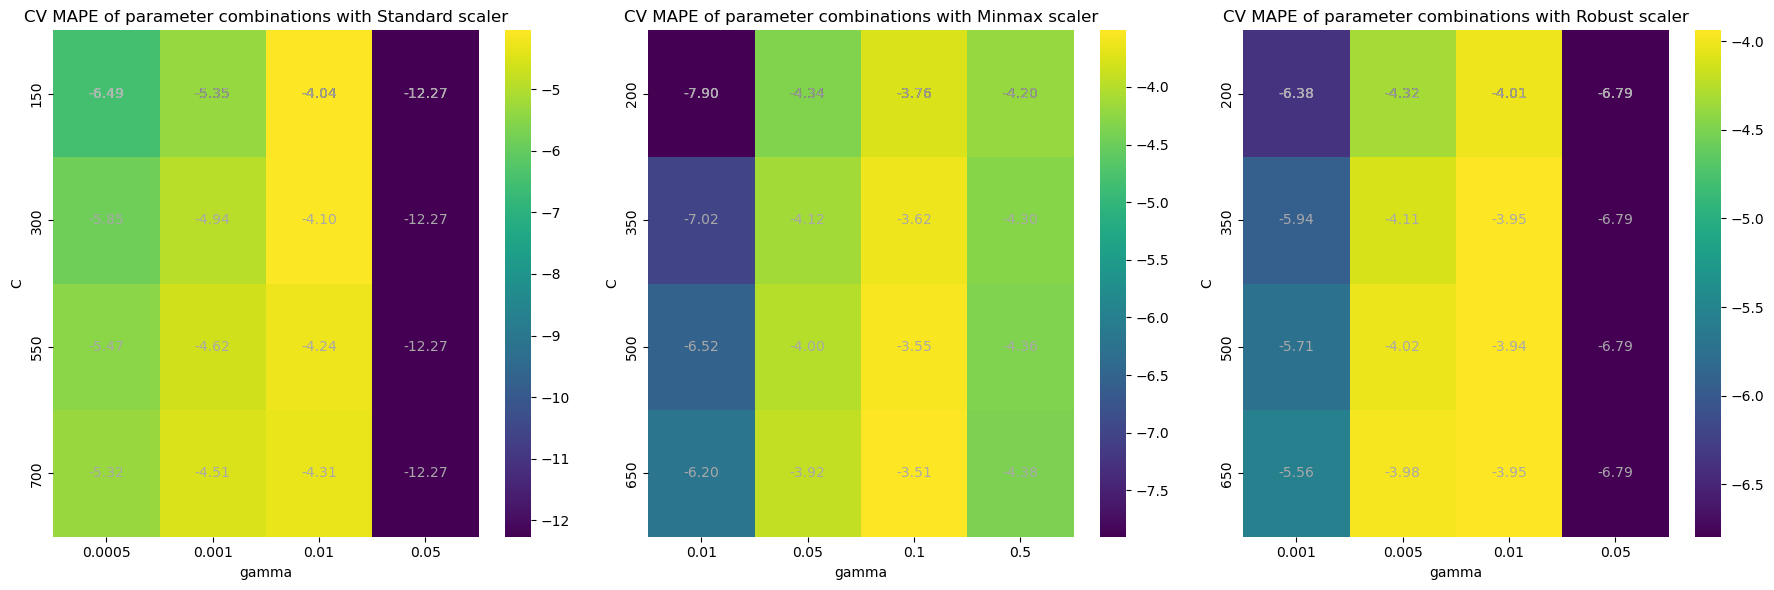

In [60]:
# Grid search cross validation
param_grid = {'Standard scaler': {'C': [150, 300, 550, 700],#?
                                  'gamma': [0.0005, 0.001, 0.01, 0.05]},
              'Minmax scaler': {'C': [200, 350, 500, 650],
                                'gamma': [0.01, 0.05, 0.1, 0.5]},
              'Robust scaler': {'C': [200, 350, 500, 650],
                                'gamma': [0.001, 0.005, 0.01, 0.05]}}

scores_list = []

for scaler_name in list(X_train_dict.keys())[:3]:
    start = time.time()
    print('----------{}----------'.format(scaler_name))

    grid_search = GridSearchCV(estimator=SVR(kernel='rbf', verbose=False), param_grid=param_grid[scaler_name], cv=3,
                            scoring='neg_mean_absolute_percentage_error', 
                            verbose=True, n_jobs=-1)

    grid_search.fit(X_train_dict[scaler_name], y_train)

    # Performance evaluation - compare train and test score
    print('MAPE on train data with {}: {} %'.format(grid_search.best_params_, np.round(-100 * grid_search.best_score_, 2))) #cv score of best parameter combination

    # Reshape mean cv test scores
    results_df = pd.DataFrame(grid_search.cv_results_)
    n_rows = len(list(param_grid[scaler_name].values())[0])
    n_cols = len(list(param_grid[scaler_name].values())[1])
    scores_list.append(np.array(results_df['mean_test_score']).reshape(n_rows, n_cols) * 100)

    print('Computation time: {} seconds\n'.format(np.round(time.time()-start, 2)))

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for scaler, ax in enumerate(axes):
    scores = scores_list[scaler]
    scaler_name = list(X_train_dict.keys())[scaler]
    
    sns.heatmap(scores, annot=True, fmt=".2f", cmap='viridis', xticklabels=param_grid[scaler_name]['gamma'], yticklabels=param_grid[scaler_name]['C'], ax=ax)
    
    # Annotating each cell with its corresponding score
    for i in range(len(scores)):
        for j in range(len(scores[i])):
            text = ax.text(j + 0.5, i + 0.5, f"{scores[i, j]:.2f}", ha='center', va='center', color='darkgrey')

    ax.set_xlabel('gamma')
    ax.set_ylabel('C')
    ax.set_title('CV MAPE of parameter combinations with {}'.format(list(X_train_dict.keys())[scaler]))

plt.tight_layout()
plt.show()

----------Standard scaler----------
Fitting 3 folds for each of 4 candidates, totalling 12 fits
MAPE on train data with {'C': 150, 'gamma': 0.01}: 4.28 %
Computation time: 4991.47 seconds

----------Minmax scaler----------
Fitting 3 folds for each of 4 candidates, totalling 12 fits
MAPE on train data with {'C': 800, 'gamma': 0.1}: 3.58 %
Computation time: 5492.55 seconds

----------Robust scaler----------
Fitting 3 folds for each of 8 candidates, totalling 24 fits
MAPE on train data with {'C': 650, 'gamma': 0.005}: 4.11 %
Computation time: 12625.04 seconds



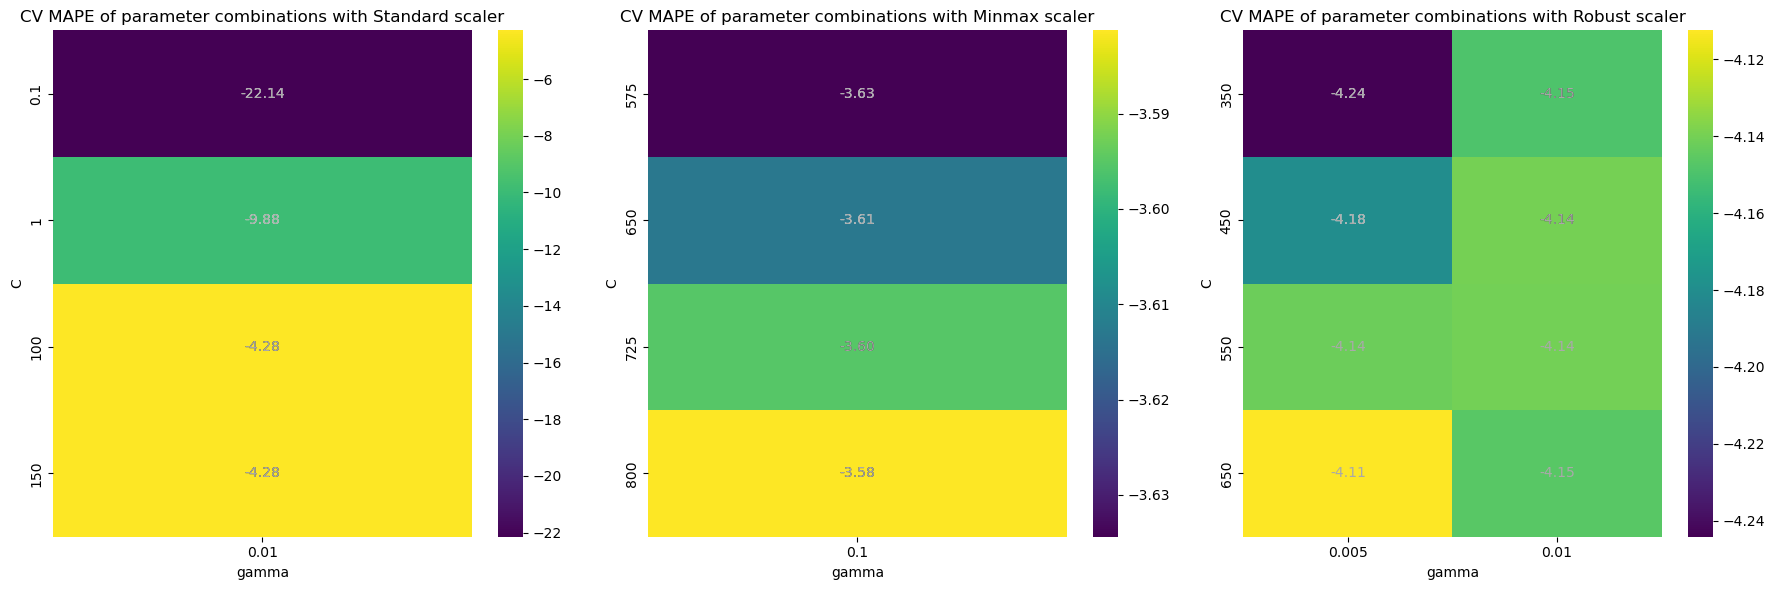

In [63]:
# Grid search cross validation
param_grid = {'Standard scaler': {'C': [0.1, 1, 100, 150],
                                  'gamma': [0.01]},
              'Minmax scaler': {'C': [575, 650, 725, 800],
                                'gamma': [0.1]},
              'Robust scaler': {'C': [350, 450, 550, 650],
                                'gamma': [0.005, 0.01]}}

scores_list = []

for scaler_name in list(X_train_dict.keys())[:3]:
    start = time.time()
    print('----------{}----------'.format(scaler_name))

    grid_search = GridSearchCV(estimator=SVR(kernel='rbf', verbose=False), param_grid=param_grid[scaler_name], cv=3,
                            scoring='neg_mean_absolute_percentage_error', 
                            verbose=True, n_jobs=-1)

    grid_search.fit(X_train_dict[scaler_name], y_train)

    # Performance evaluation - compare train and test score
    print('MAPE on train data with {}: {} %'.format(grid_search.best_params_, np.round(-100 * grid_search.best_score_, 2))) #cv score of best parameter combination

    # Reshape mean cv test scores
    results_df = pd.DataFrame(grid_search.cv_results_)
    n_rows = len(list(param_grid[scaler_name].values())[0])
    n_cols = len(list(param_grid[scaler_name].values())[1])
    scores_list.append(np.array(results_df['mean_test_score']).reshape(n_rows, n_cols) * 100)

    print('Computation time: {} seconds\n'.format(np.round(time.time()-start, 2)))

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for scaler, ax in enumerate(axes):
    scores = scores_list[scaler]
    scaler_name = list(X_train_dict.keys())[scaler]
    
    sns.heatmap(scores, annot=True, fmt=".2f", cmap='viridis', xticklabels=param_grid[scaler_name]['gamma'], yticklabels=param_grid[scaler_name]['C'], ax=ax)
    
    # Annotating each cell with its corresponding score
    for i in range(len(scores)):
        for j in range(len(scores[i])):
            text = ax.text(j + 0.5, i + 0.5, f"{scores[i, j]:.2f}", ha='center', va='center', color='darkgrey')

    ax.set_xlabel('gamma')
    ax.set_ylabel('C')
    ax.set_title('CV MAPE of parameter combinations with {}'.format(list(X_train_dict.keys())[scaler]))

plt.tight_layout()
plt.show()

----------Standard scaler----------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
MAPE on train data with {'C': 150, 'gamma': 0.01}: 4.04 %
Computation time: 12272.6 seconds

----------Minmax scaler----------
Fitting 3 folds for each of 4 candidates, totalling 12 fits
MAPE on train data with {'C': 1000, 'gamma': 0.1}: 3.45 %
Computation time: 16949.16 seconds

----------Robust scaler----------
Fitting 3 folds for each of 8 candidates, totalling 24 fits
MAPE on train data with {'C': 450, 'gamma': 0.01}: 3.94 %
Computation time: 42548.68 seconds



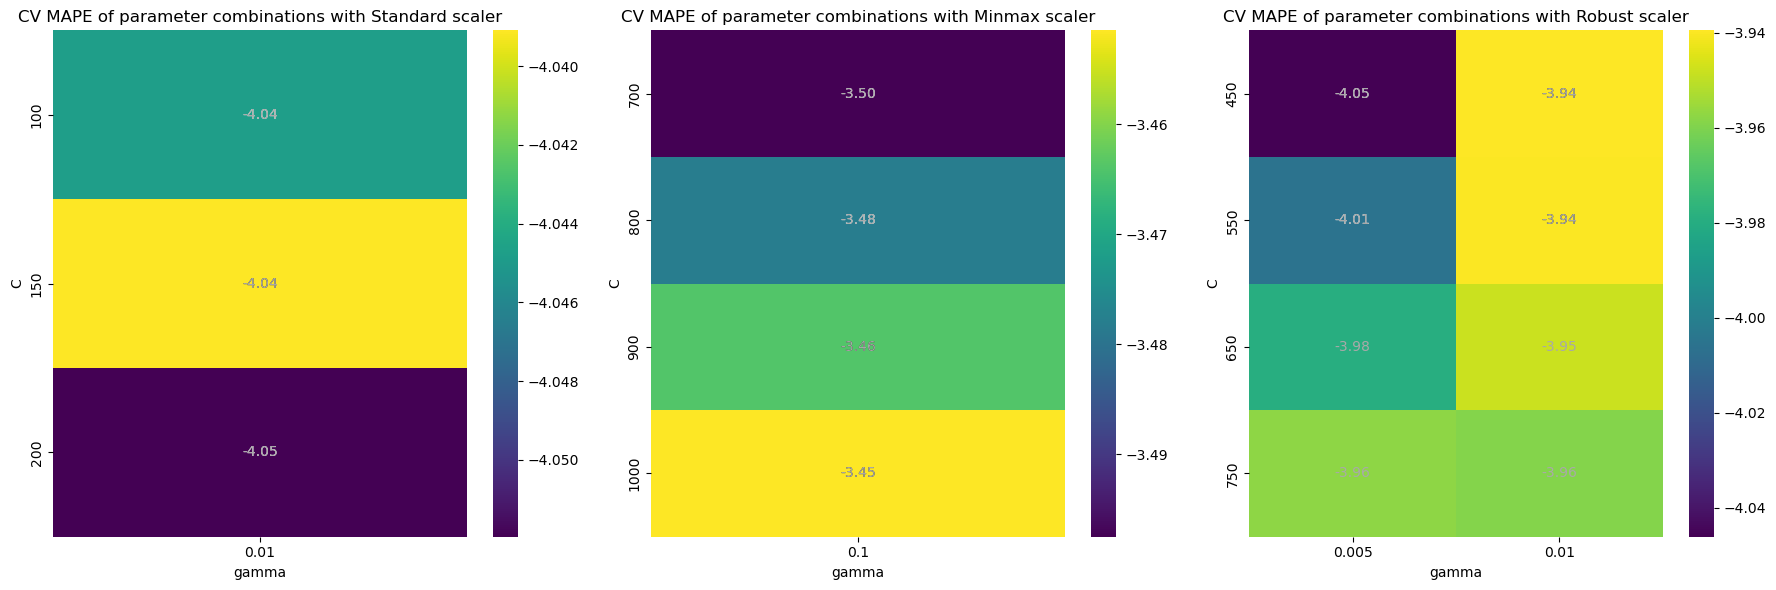

In [11]:
# Grid search cross validation
param_grid = {'Standard scaler': {'C': [100, 150, 200],
                                  'gamma': [0.01]},
              'Minmax scaler': {'C': [700, 800, 900, 1000],
                                'gamma': [0.1]},
              'Robust scaler': {'C': [450, 550, 650, 750],
                                'gamma': [0.005, 0.01]}}

scores_list = []

for scaler_name in list(X_train_dict.keys())[:3]:
    start = time.time()
    print('----------{}----------'.format(scaler_name))

    grid_search = GridSearchCV(estimator=SVR(kernel='rbf', verbose=False), param_grid=param_grid[scaler_name], cv=3,
                            scoring='neg_mean_absolute_percentage_error', 
                            verbose=True, n_jobs=-1)

    grid_search.fit(X_train_dict[scaler_name], y_train)

    # Performance evaluation - compare train and test score
    print('MAPE on train data with {}: {} %'.format(grid_search.best_params_, np.round(-100 * grid_search.best_score_, 2))) #cv score of best parameter combination

    # Reshape mean cv test scores
    results_df = pd.DataFrame(grid_search.cv_results_)
    n_rows = len(list(param_grid[scaler_name].values())[0])
    n_cols = len(list(param_grid[scaler_name].values())[1])
    scores_list.append(np.array(results_df['mean_test_score']).reshape(n_rows, n_cols) * 100)

    print('Computation time: {} seconds\n'.format(np.round(time.time()-start, 2)))

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for scaler, ax in enumerate(axes):
    scores = scores_list[scaler]
    scaler_name = list(X_train_dict.keys())[scaler]
    
    sns.heatmap(scores, annot=True, fmt=".2f", cmap='viridis', xticklabels=param_grid[scaler_name]['gamma'], yticklabels=param_grid[scaler_name]['C'], ax=ax)
    
    # Annotating each cell with its corresponding score
    for i in range(len(scores)):
        for j in range(len(scores[i])):
            text = ax.text(j + 0.5, i + 0.5, f"{scores[i, j]:.2f}", ha='center', va='center', color='darkgrey')

    ax.set_xlabel('gamma')
    ax.set_ylabel('C')
    ax.set_title('CV MAPE of parameter combinations with {}'.format(list(X_train_dict.keys())[scaler]))

plt.tight_layout()
plt.show()